# Steel plate faults multiclass classification

In [3]:
# load libraries
from e2eml.classification import classification_blueprints as cb
from e2eml.full_processing.postprocessing import save_to_production, load_for_production
from e2eml.test.classification_blueprints_test import steel_fault_multiclass_data
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report

# Feature engineering
Load & preprocess steel faults dataset.

In [4]:
# load steel faults data
test_df, test_target, val_df, val_df_target, test_categorical_cols = steel_fault_multiclass_data()


# Using e2eml - Run and save a pipeline
In this notebook we configure a custom pipeline. Due to the object-oriented approach we can easily set this up.
Under the hood the main and mostly used blueprint pipeline looks like this:

In [5]:
"""def pipeline(self):
        logging.info('Start blueprint.')
        try:
            if df.empty:
                self.prediction_mode = False
            else:
                self.dataframe = df
                self.prediction_mode = True
        except AttributeError:
            self.prediction_mode = False
        self.train_test_split(how=self.train_split_type)
        self.datetime_converter(datetime_handling='all', force_conversion=False)
        if preprocessing_type == 'nlp':
            self.pos_tagging_pca()
        self.rare_feature_processor(threshold=0.03, mask_as='miscellaneous')
        self.cardinality_remover(threshold=100)
        self.onehot_pca()
        self.category_encoding(algorithm='target')
        self.delete_high_null_cols(threshold=0.5)
        self.fill_nulls(how='static')
        self.data_binning(nb_bins=10)
        #self.skewness_removal()
        self.outlier_care(method='isolation', how='append')
        self.remove_collinearity(threshold=0.8)
        self.clustering_as_a_feature(algorithm='dbscan', eps=0.3, n_jobs=-1, min_samples=10)
        for nb_cluster in range(2, 10):
            self.clustering_as_a_feature(algorithm='kmeans', nb_clusters=nb_cluster)
        if self.low_memory_mode:
            self.reduce_memory_footprint()
        self.automated_feature_selection(metric='logloss')
        self.sort_columns_alphabetically()
        if self.prediction_mode:
            pass
        else:
            self.lgbm_train(tune_mode=self.tune_mode)
        self.lgbm_predict(feat_importance=True)
        self.classification_eval('lgbm')
        self.prediction_mode = True
        logging.info('Finished blueprint.')"""

"def pipeline(self):\n        logging.info('Start blueprint.')\n        try:\n            if df.empty:\n                self.prediction_mode = False\n            else:\n                self.dataframe = df\n                self.prediction_mode = True\n        except AttributeError:\n            self.prediction_mode = False\n        self.train_test_split(how=self.train_split_type)\n        self.datetime_converter(datetime_handling='all', force_conversion=False)\n        if preprocessing_type == 'nlp':\n            self.pos_tagging_pca()\n        self.rare_feature_processor(threshold=0.03, mask_as='miscellaneous')\n        self.cardinality_remover(threshold=100)\n        self.onehot_pca()\n        self.category_encoding(algorithm='target')\n        self.delete_high_null_cols(threshold=0.5)\n        self.fill_nulls(how='static')\n        self.data_binning(nb_bins=10)\n        #self.skewness_removal()\n        self.outlier_care(method='isolation', how='append')\n        self.remove_collinea

From here we can make custom choices by:
- skipping steps
- changing parameters
- or even extend

We follow these steps:
- instantiate class
- define and run pipeline
- save and load pipeline
- predict on new data

In [6]:
# Instantiate class
steel_faults_ml = cb.ClassificationBluePrint(datasource=test_df,
                                       target_variable=test_target,
                                       categorical_columns=test_categorical_cols,
                                       preferred_training_mode='auto',
                                       tune_mode='accurate')

Ml task is multiclass
Preferred training mode auto has been chosen. e2eml will automatically detect, if LGBM and Xgboost can use GPU acceleration and optimize the workflow accordingly.


In [7]:
"""
Define custom pipeline...
- Please note, that there are logical and technical dependencies. Not everything is possible.
"""
def custom_pipeline(df, steel_faults_ml):
    try:
        if df.empty:
            steel_faults_ml.prediction_mode = False
        else:
            steel_faults_ml.dataframe = df
            steel_faults_ml.prediction_mode = True
    except AttributeError:
        steel_faults_ml.prediction_mode = False
    steel_faults_ml.train_test_split(how=steel_faults_ml.train_split_type)
    try:
        print(steel_faults_ml.df_dict["Y_train"])
    except AttributeError:
        #does not exist in prediction mode
        pass
    steel_faults_ml.datetime_converter(datetime_handling='all', force_conversion=False)
    steel_faults_ml.pos_tagging_pca()
    # we removed rare feature processing
    steel_faults_ml.cardinality_remover(threshold=200) #raised
    steel_faults_ml.onehot_pca()
    steel_faults_ml.category_encoding(algorithm='target')
    """
    Custom pipelines allow you to inject your own data manipulation or to access the data in between.
    The train and test data is always stored in the df_dict attribute.
    """
    try:
        print(steel_faults_ml.df_dict["X_train"].isna().sum())
    except AttributeError:
        #changed location in prediction mode
        print(steel_faults_ml.dataframe.isna().sum())
    steel_faults_ml.delete_high_null_cols(threshold=0.4) # lowered to 40%
    steel_faults_ml.fill_nulls(how='iterative_imputation') # we changed to iterative filling instead of imputation with 0
    steel_faults_ml.data_binning(nb_bins=5) # we change the bins
    steel_faults_ml.outlier_care(method='isolation', how='append')
    steel_faults_ml.remove_collinearity(threshold=0.8)
    steel_faults_ml.clustering_as_a_feature(algorithm='dbscan', eps=0.3, n_jobs=-1, min_samples=10)
    for nb_cluster in range(2, 20):
        steel_faults_ml.clustering_as_a_feature(algorithm='GLMM', nb_clusters=nb_cluster) #changed from kmeans
    steel_faults_ml.automated_feature_selection(metric='logloss') # needs to be xgboost compatible
    steel_faults_ml.sort_columns_alphabetically()
    if steel_faults_ml.prediction_mode:
        pass
    else:
        steel_faults_ml.lgbm_train(tune_mode=steel_faults_ml.tune_mode)
    steel_faults_ml.lgbm_predict(feat_importance=True)
    steel_faults_ml.classification_eval('lgbm')
    steel_faults_ml.prediction_mode = True # mandatory


Started Execute test train split at 19:03:30.
Started Execute label encoding at 19:03:30.
Started Execute label encoding at 19:03:30.
1221    0
495     1
532     1
1249    0
942     0
       ..
1555    2
694     1
1376    2
1038    0
1188    0
Name: target, Length: 1200, dtype: int64
Started Apply datetime transformation at 19:03:30.
Started Start Spacy, POS tagging at 19:03:30.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 1221 to 1188
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1200 non-null   int64  
 1   X_Maximum              1183 non-null   float64
 2   Y_Minimum              1200 non-null   int64  
 3   Y_Maximum              1200 non-null   int64  
 4   Pixels_Areas           1200 non-null   int64  
 5   X_Perimeter            1200 non-null   int64  
 6   Y_Perimeter            1200 non-null   int64  
 7   Sum_of_Luminosity      1200 non-nul

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


X_Minimum                 0
X_Maximum                17
Y_Minimum                 0
Y_Maximum                 0
Pixels_Areas              0
X_Perimeter               0
Y_Perimeter               0
Sum_of_Luminosity         0
Minimum_of_Luminosity     0
Maximum_of_Luminosity     0
Length_of_Conveyer        0
TypeOfSteel_A300          0
TypeOfSteel_A400          0
Steel_Plate_Thickness    21
Edges_Index               0
Empty_Index              16
Square_Index              0
Outside_X_Index           0
Edges_X_Index             0
Edges_Y_Index             0
Outside_Global_Index      0
LogOfAreas                0
Log_X_Index               0
Log_Y_Index               0
Orientation_Index         0
Luminosity_Index          0
SigmoidOfAreas            0
dtype: int64
Started  Delete columns with high share of NULLs at 19:03:31.
Started Fill nulls at 19:03:31.
Started Execute numerical binning at 19:03:31.
Started Handle outliers at 19:03:31.
Started Remove collinearity at 19:03:32.
Started Exec

Found `num_iterations` in params. Will use it instead of argument
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[I 2021-08-01 19:03:33,091] A new study created in memory with name: no-name-59105e42-e3b1-4daf-8418-98deec522495
Found `num_boost_round` in params. Will use it instead of argument
[I 2021-08-01 19:03:33,185] Trial 0 finished with value: 1.9463440056754628 and parameters: {'num_boost_round': 14189, 'lambda_l1': 899.67371185966, 'lambda_l2': 18567.819389687826, 'num_leaves': 85, 'feature_fraction': 0.42507530132538834, 'bagging_freq': 6, 'min_child_samples': 9, 'min_gain_to_split': 0.7673977140858844, 'learning_rate': 0.018678289306974342}. Best is trial 0 with value: 1.9463440056754628.


Started Sort columns alphabetically at 19:03:33.
Started Train LGBM at 19:03:33.
Started Check LGBM for GPU acceleration. at 19:03:33.
LGBM uses CPU.


Found `num_boost_round` in params. Will use it instead of argument
[I 2021-08-01 19:03:33,261] Trial 1 finished with value: 1.9463440056754626 and parameters: {'num_boost_round': 2690, 'lambda_l1': 2522.712509997782, 'lambda_l2': 2.000534609250653, 'num_leaves': 230, 'feature_fraction': 0.4474065305489644, 'bagging_freq': 5, 'min_child_samples': 58, 'min_gain_to_split': 0.8685910754220993, 'learning_rate': 3.7974222342283656e-05}. Best is trial 1 with value: 1.9463440056754626.
Found `num_boost_round` in params. Will use it instead of argument
[I 2021-08-01 19:07:12,179] Trial 2 finished with value: 1.8759056108919714 and parameters: {'num_boost_round': 10937, 'lambda_l1': 2.097501648395253, 'lambda_l2': 6.612338497114956, 'num_leaves': 128, 'feature_fraction': 0.5953444285440685, 'bagging_freq': 1, 'min_child_samples': 56, 'min_gain_to_split': 0.4538569322169048, 'learning_rate': 7.037291455730024e-06}. Best is trial 2 with value: 1.8759056108919714.
Found `num_boost_round` in params.

Found `num_boost_round` in params. Will use it instead of argument
[I 2021-08-01 19:34:33,733] Trial 18 finished with value: 1.2909517359866622 and parameters: {'num_boost_round': 32429, 'lambda_l1': 3.641502228589136, 'lambda_l2': 233.40108331176964, 'num_leaves': 115, 'feature_fraction': 0.9708876441558485, 'bagging_freq': 3, 'min_child_samples': 100, 'min_gain_to_split': 0.9908091894113191, 'learning_rate': 0.0002521651707416071}. Best is trial 18 with value: 1.2909517359866622.
Found `num_boost_round` in params. Will use it instead of argument
[I 2021-08-01 19:34:33,799] Trial 19 finished with value: 100.0 and parameters: {'num_boost_round': 44909, 'lambda_l1': 125.88421731566469, 'lambda_l2': 2882.302933960455, 'num_leaves': 111, 'feature_fraction': 0.972923474962058, 'bagging_freq': 3, 'min_child_samples': 100, 'min_gain_to_split': 0.9307212637152726, 'learning_rate': 4.097134139028419e-07}. Best is trial 18 with value: 1.2909517359866622.
Found `num_boost_round` in params. Will 

Found `num_boost_round` in params. Will use it instead of argument
[I 2021-08-01 19:35:40,132] Trial 35 finished with value: 100.0 and parameters: {'num_boost_round': 914, 'lambda_l1': 29.819371763512905, 'lambda_l2': 1.5826850004325261, 'num_leaves': 126, 'feature_fraction': 0.8826006702048188, 'bagging_freq': 7, 'min_child_samples': 75, 'min_gain_to_split': 0.001981637535113989, 'learning_rate': 0.0052032989016836785}. Best is trial 31 with value: 0.7272199455518277.
Found `num_boost_round` in params. Will use it instead of argument
[I 2021-08-01 19:35:40,514] Trial 36 finished with value: 100.0 and parameters: {'num_boost_round': 16961, 'lambda_l1': 1.9453454644710462, 'lambda_l2': 4.11519710717149, 'num_leaves': 174, 'feature_fraction': 0.7802009381424594, 'bagging_freq': 5, 'min_child_samples': 64, 'min_gain_to_split': 0.24040093009315483, 'learning_rate': 0.010847479468383854}. Best is trial 31 with value: 0.7272199455518277.
Found `num_boost_round` in params. Will use it instead

[1]	train's multi_logloss: 1.66898	valid's multi_logloss: 1.67695
Training until validation scores don't improve for 10 rounds
[2]	train's multi_logloss: 1.65158	valid's multi_logloss: 1.66054
[3]	train's multi_logloss: 1.63417	valid's multi_logloss: 1.64414
[4]	train's multi_logloss: 1.61721	valid's multi_logloss: 1.62813
[5]	train's multi_logloss: 1.60087	valid's multi_logloss: 1.6123
[6]	train's multi_logloss: 1.58489	valid's multi_logloss: 1.59728
[7]	train's multi_logloss: 1.57023	valid's multi_logloss: 1.58378
[8]	train's multi_logloss: 1.55501	valid's multi_logloss: 1.56945
[9]	train's multi_logloss: 1.54025	valid's multi_logloss: 1.55578
[10]	train's multi_logloss: 1.52607	valid's multi_logloss: 1.54247
[11]	train's multi_logloss: 1.51232	valid's multi_logloss: 1.52964
[12]	train's multi_logloss: 1.49859	valid's multi_logloss: 1.517
[13]	train's multi_logloss: 1.48525	valid's multi_logloss: 1.5045
[14]	train's multi_logloss: 1.4728	valid's multi_logloss: 1.49287
[15]	train's mu

[144]	train's multi_logloss: 0.757667	valid's multi_logloss: 0.819298
[145]	train's multi_logloss: 0.755336	valid's multi_logloss: 0.817333
[146]	train's multi_logloss: 0.75312	valid's multi_logloss: 0.815602
[147]	train's multi_logloss: 0.750894	valid's multi_logloss: 0.813701
[148]	train's multi_logloss: 0.748752	valid's multi_logloss: 0.811706
[149]	train's multi_logloss: 0.746568	valid's multi_logloss: 0.809742
[150]	train's multi_logloss: 0.744402	valid's multi_logloss: 0.807943
[151]	train's multi_logloss: 0.742224	valid's multi_logloss: 0.806002
[152]	train's multi_logloss: 0.740028	valid's multi_logloss: 0.804223
[153]	train's multi_logloss: 0.737963	valid's multi_logloss: 0.802377
[154]	train's multi_logloss: 0.735861	valid's multi_logloss: 0.80058
[155]	train's multi_logloss: 0.733725	valid's multi_logloss: 0.798705
[156]	train's multi_logloss: 0.731691	valid's multi_logloss: 0.796985
[157]	train's multi_logloss: 0.729628	valid's multi_logloss: 0.795219
[158]	train's multi_lo

[352]	train's multi_logloss: 0.503007	valid's multi_logloss: 0.625887
[353]	train's multi_logloss: 0.502308	valid's multi_logloss: 0.625474
[354]	train's multi_logloss: 0.501689	valid's multi_logloss: 0.625084
[355]	train's multi_logloss: 0.500978	valid's multi_logloss: 0.624652
[356]	train's multi_logloss: 0.50025	valid's multi_logloss: 0.62407
[357]	train's multi_logloss: 0.499673	valid's multi_logloss: 0.623858
[358]	train's multi_logloss: 0.498951	valid's multi_logloss: 0.623588
[359]	train's multi_logloss: 0.498297	valid's multi_logloss: 0.623229
[360]	train's multi_logloss: 0.497537	valid's multi_logloss: 0.622763
[361]	train's multi_logloss: 0.496931	valid's multi_logloss: 0.622436
[362]	train's multi_logloss: 0.496244	valid's multi_logloss: 0.622023
[363]	train's multi_logloss: 0.49562	valid's multi_logloss: 0.621606
[364]	train's multi_logloss: 0.495012	valid's multi_logloss: 0.621019
[365]	train's multi_logloss: 0.494353	valid's multi_logloss: 0.620706
[366]	train's multi_log

[553]	train's multi_logloss: 0.397471	valid's multi_logloss: 0.570298
[554]	train's multi_logloss: 0.397049	valid's multi_logloss: 0.570267
[555]	train's multi_logloss: 0.396682	valid's multi_logloss: 0.570241
[556]	train's multi_logloss: 0.39631	valid's multi_logloss: 0.569987
[557]	train's multi_logloss: 0.395895	valid's multi_logloss: 0.569813
[558]	train's multi_logloss: 0.395467	valid's multi_logloss: 0.569602
[559]	train's multi_logloss: 0.395117	valid's multi_logloss: 0.56953
[560]	train's multi_logloss: 0.394679	valid's multi_logloss: 0.569229
[561]	train's multi_logloss: 0.394286	valid's multi_logloss: 0.568983
[562]	train's multi_logloss: 0.393943	valid's multi_logloss: 0.568829
[563]	train's multi_logloss: 0.393541	valid's multi_logloss: 0.568632
[564]	train's multi_logloss: 0.393129	valid's multi_logloss: 0.568473
[565]	train's multi_logloss: 0.392708	valid's multi_logloss: 0.568274
[566]	train's multi_logloss: 0.392339	valid's multi_logloss: 0.568014
[567]	train's multi_lo

[737]	train's multi_logloss: 0.340262	valid's multi_logloss: 0.552458
[738]	train's multi_logloss: 0.340016	valid's multi_logloss: 0.552362
[739]	train's multi_logloss: 0.339779	valid's multi_logloss: 0.552344
[740]	train's multi_logloss: 0.339511	valid's multi_logloss: 0.552325
[741]	train's multi_logloss: 0.3393	valid's multi_logloss: 0.552229
[742]	train's multi_logloss: 0.339048	valid's multi_logloss: 0.552175
[743]	train's multi_logloss: 0.338813	valid's multi_logloss: 0.552028
[744]	train's multi_logloss: 0.338562	valid's multi_logloss: 0.552021
[745]	train's multi_logloss: 0.338342	valid's multi_logloss: 0.551973
[746]	train's multi_logloss: 0.33807	valid's multi_logloss: 0.55192
[747]	train's multi_logloss: 0.337818	valid's multi_logloss: 0.551856
[748]	train's multi_logloss: 0.337568	valid's multi_logloss: 0.551781
[749]	train's multi_logloss: 0.337305	valid's multi_logloss: 0.551727
[750]	train's multi_logloss: 0.337071	valid's multi_logloss: 0.551682
[751]	train's multi_logl

Started Predict with LGBM at 19:35:48.


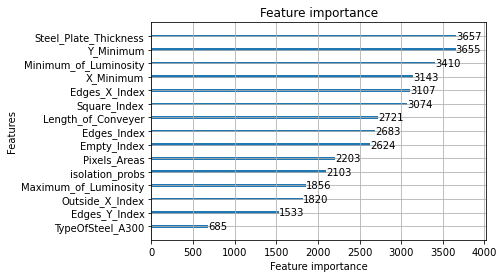

<Figure size 1152x864 with 0 Axes>

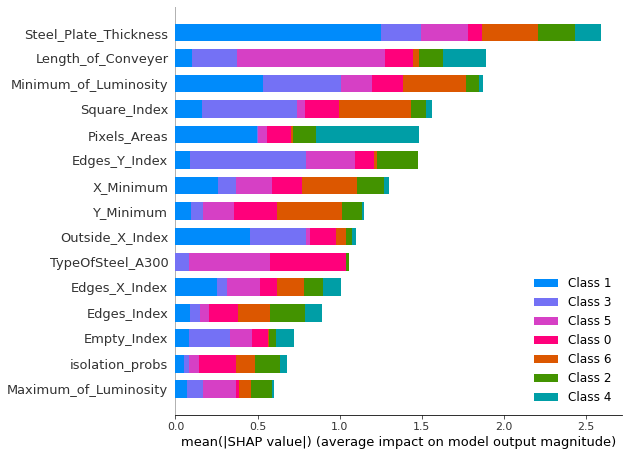

The Matthew correlation is 0.7139040686745433
-------------------
The accuracy is 0.7766666666666666
The macro F1 score is 0.8159576225302515
The micro F1 score is 0.7766666666666666
The weighted F1 score is 0.7749174965666562
              precision    recall  f1-score   support

           0       0.73      0.57      0.64        67
           1       0.92      0.95      0.94        62
           2       0.65      0.80      0.71        99
           3       0.75      0.57      0.65        21
           4       1.00      1.00      1.00        16
           5       0.96      0.85      0.90        26
           6       1.00      0.78      0.88         9

    accuracy                           0.78       300
   macro avg       0.86      0.79      0.82       300
weighted avg       0.79      0.78      0.77       300



In [8]:
# Run custom blueprint
custom_pipeline(None, steel_faults_ml)

In [9]:
# Save pipeline
try:
    save_to_production(steel_faults_ml, file_name='steel_faults_instance')
except AttributeError:
    print("""Unfortunately this does not work with version 0.9.4 when e2eml has to label encode the target labels automatically.
    For saving a pipeline please provide encoded target labels. This is solved for all other releases.""")

# Predict on new data
In the beginning we kept a holdout dataset. We use this to simulate prediction on completely new data.

In [10]:
# load stored pipeline...we skip this accordingly
steel_faults_ml_loaded = load_for_production(file_name='steel_faults_instance')

In [11]:
# label encode targets
val_df_target = steel_faults_ml_loaded.label_encoder_decoder(val_df_target, mode='transform')

# predict on new data
custom_pipeline(val_df, steel_faults_ml_loaded)

# access predicted labels
val_y_hat = steel_faults_ml_loaded.predicted_classes['lgbm']

Started Execute label encoding at 19:35:49.
Started Execute test train split at 19:35:49.
Started Apply datetime transformation at 19:35:49.
Started Start Spacy, POS tagging at 19:35:49.
Started Remove cardinality at 19:35:49.
Started Onehot + PCA categorical features at 19:35:49.
Started Execute categorical encoding at 19:35:49.
X_Minimum                0
X_Maximum                2
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    6
Edges_Index              0
Empty_Index              6
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index   

In [12]:
# Assess prediction quality on holdout data
print(classification_report(val_df_target, val_y_hat))
try:
    matthews = matthews_corrcoef(val_df_target, val_y_hat)
except Exception:
    print("Matthew failed.")
    matthews = 0
print(matthews)

              precision    recall  f1-score   support

           0       0.70      0.59      0.64        94
           1       0.96      0.94      0.95        78
           2       0.69      0.75      0.72       171
           3       0.55      0.51      0.53        35
           4       0.87      0.87      0.87        15
           5       0.89      0.95      0.92        43
           6       1.00      1.00      1.00         5

    accuracy                           0.76       441
   macro avg       0.81      0.80      0.80       441
weighted avg       0.76      0.76      0.76       441

0.6774769114326497
